In [1]:
import pertpy as pt


/software/cellgen/team298/ls34/sccoda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from pertpy.tl import EdgeR

In [3]:
import warnings

import decoupler as dc
import scanpy as sc

warnings.filterwarnings("ignore")

## Dataset

In [6]:
PATH = '/nfs/team298/ls34/adult_skin/final_adatas/adata_combined_new.h5ad.final.filtered'
adata_5k=sc.read_h5ad(PATH)
adata_5k=adata_5k[adata_5k.obs["tech"]=="xenium"].copy()
import gc
gc.collect()


def remove_markers(LIST):
    try: 
        LIST = {key: [gene for gene in genes if gene in adata_5k.var_names] 
                           for key, genes in LIST.items()}
    except: 
        LIST =[gene for gene in LIST if gene in adata_5k.var_names]
    return LIST



adata_5k.obs["lvl5_annotation_new"]=adata_5k.obs["lvl5_annotation"]

adata=adata_5k



In [10]:
adata = adata[adata.obs["Site_status"] == "Lesional", :].copy()
adata.obs.Site_status_binary.value_counts()
adata.obs["Patient"]=adata.obs["Sanger patient ID"]
#adata.obs["Patient"]=adata.obs["sample_id"]
adata.obs["Sample"]=adata.obs["sample_id"]
# Step 1: Calculate total counts per patient
patient_counts = adata.obs.groupby("Patient").size()

# Step 2: Identify patients with more than 5000 counts
patients_to_exclude = patient_counts[patient_counts < 10000].index

# Step a: Exclude those patients from adata
#adata = adata[~adata.obs["Patient"].isin(patients_to_exclude)].copy()
#adata=adata[adata.obs["Timepoint"]!="UNKNOWN_FFPE"]
#a#data.obs["Patient"].value_counts()
#adata=adata[~adata.obs["Patient"].isin(['BK50', 'BK49', 'BK43', 'BK46', 'BK51'])]
adata.obs["Group"]=adata.obs["Site_status_binary"]
adata.obs["Major celltype"] = adata.obs["lvl0"]
adata.obs["Cluster"]=adata.obs["lvl4_annotation"] 

In [11]:
for x in adata.obs.columns:
    if x not in ["Cluster", "Major celltype", "disease_overall", "Site_status", "Group", "Sample", "Patient"]:
        del(adata.obs[x])


AnnData object with n_obs × n_vars = 231621 × 4993
    obs: 'Site_status', 'disease_overall', 'Patient', 'Sample', 'Group', 'Major celltype', 'Cluster'
    uns: 'leiden', 'leiden_res0.1', 'lvl5_annotation_colors', 'lvl6_annotation_colors', 'neighbor_10', 'niche14_colors', 'niche19_colors', 'provisional_colors', 'scanvi_predictions2_colors', 'tech_colors', 'test_colors', 'umap'
    obsm: 'X_scvi', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'neighbor_10_connectivities', 'neighbor_10_distances'

In [12]:
# {x:"" for x in adata[adata.obs["disease_overall"]=="Psoriasis"].obs["Sample"].unique()}

{'Lesional_CE5-SKI-28-FO-1-S22-A1': '',
 'Lesional_CE6-SKI-28-FO-4-S22-A1': '',
 'Lesional_CE3-SKI-24-FO-1-S22-A1': '',
 'Lesional_CE4-SKI-27-FO-4-S22-A2': ''}

When conducting differential gene expression analysis, it is important to understand the dataset well.
We will therefore explore the various co-variates first.

In [13]:
# RENAME = {'output-XETG00155__0056910__CE6-SKI-28-FO-1-S22-B2__20250321__130447': 'CE6',
#  'output-XETG00155__0056910__CE5-SKI-28-FO-1-S22-A1__20250321__130447': 'CE5',
#  'output-XETG00155__0056918__CE3-SKI-28-FO-1-S22-B1__20250321__130447': 'CE3',
#  'output-XETG00155__0056918__CE4-SKI-27-FO-1-S22-B2__20250321__130447': 'CE4',
#  'output-XETG00155__0056910__CE6-SKI-28-FO-4-S22-A1__20250321__130447': 'CE6',
#  'output-XETG00155__0056910__CE5-SKI-27-FO-2-S22-C1__20250321__130447': 'CE5',
#  'output-XETG00155__0056918__CE3-SKI-24-FO-1-S22-A1__20250321__130447': 'CE3',
#  'output-XETG00155__0056918__CE4-SKI-21-FO-1-S22-C2__20250321__130447': 'CE4',
#  'output-XETG00155__0056910__CE5-SKI-27-FO-1-S22-B1__20250321__130447': 'CE5',
#  'output-XETG00155__0056918__CE3-SKI-28-FO-2-S22-C1__20250321__130447': 'CE3',
#  'output-XETG00155__0056918__CE4-SKI-27-FO-4-S22-A2__20250321__130447': 'CE4',
#  'output-XETG00155__0056910__CE6-SKI-20-FO-1-S22-C2__20250321__130447': 'CE6'}
# adata.obs["Patient"] = adata.obs["Sample"].map(RENAME).fillna(adata.obs["Patient"])

## Pseudobulks

In [32]:
adata.X=adata.layers["counts"].copy()

In [35]:
adata.obs["Drug"]=adata.obs["Group"]
adata.obs["Drug"]=adata.obs["Drug"].astype(str)
#adata.obs["Group"]=adata.obs["Group"].astype('category')
adata.obs["Group2"]=adata.obs["Group"].astype(str)

adata

AnnData object with n_obs × n_vars = 231621 × 4993
    obs: 'Site_status', 'disease_overall', 'Patient', 'Sample', 'Group', 'Major celltype', 'Cluster', 'Drug', 'Group2'
    uns: 'leiden', 'leiden_res0.1', 'lvl5_annotation_colors', 'lvl6_annotation_colors', 'neighbor_10', 'niche14_colors', 'niche19_colors', 'provisional_colors', 'scanvi_predictions2_colors', 'tech_colors', 'test_colors', 'umap'
    obsm: 'X_scvi', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'neighbor_10_connectivities', 'neighbor_10_distances'

In [38]:
adata_i=adata[adata.obs["Site_status"]=="Lesional"]

In [42]:
adata_i=adata_i[(adata_i.obs["Cluster"].str.startswith("MigDC (cDC2"))
              # (adata_i.obs["Cluster"].str.startswith("F1"))
               ].copy()

In [43]:
adata_i=adata_i.copy()

In [68]:
ps = pt.tl.PseudobulkSpace()
pdata = ps.compute(
    adata_i, 
    target_col='disease_overall',
    #target_col="disease_overall",
   groups_col="Patient", 
    layer_key="counts", mode="sum", min_cells=20, min_counts=1000
)
pdata.obs

,disease_overall,Patient,Site_status,Sample,Group,Cluster,Drug,Group2,psbulk_n_cells,psbulk_counts
AD_BK18,AD,BK18,Lesional,BK18_Lesional Baseline,Lesional,MigDC (cDC2),Lesional,Lesional,185.0,51135.0
AD_BK21,AD,BK21,Lesional,BK21_Lesional Baseline,Lesional,MigDC (cDC2),Lesional,Lesional,248.0,65112.0
AD_BK22,AD,BK22,Lesional,BK22_Lesional Baseline,Lesional,MigDC (cDC2),Lesional,Lesional,334.0,298476.0
AD_BK23,AD,BK23,Lesional,BK23_Lesional Baseline,Lesional,MigDC (cDC2),Lesional,Lesional,113.0,37822.0
AD_BK25,AD,BK25,Lesional,BK25_Lesional Baseline,Lesional,MigDC (cDC2),Lesional,Lesional,138.0,109679.0
AD_BK30,AD,BK30,Lesional,BK30_Lesional Baseline,Lesional,MigDC (cDC2),Lesional,Lesional,83.0,27336.0
AD_BK39,AD,BK39,Lesional,BK39_Lesional Baseline,Lesional,MigDC (cDC2),Lesional,Lesional,158.0,53937.0
AD_BK51,AD,BK51,Lesional,BK51_wk8 Relapse,Lesional,MigDC (cDC2),Lesional,Lesional,94.0,64343.0
Psoriasis_CE3,Psoriasis,CE3,Lesional,Lesional_CE3-SKI-24-FO-1-S22-A1,Lesional,MigDC (cDC2),Lesional,Lesional,214.0,74523.0
Psoriasis_CE4,Psoriasis,CE4,Lesional,Lesional_CE4-SKI-27-FO-4-S22-A2,Lesional,MigDC (cDC2),Lesional,Lesional,275.0,112848.0


In [74]:
pdata.layers["counts"] = pdata.X.copy()
#pdata.X=pdata.layers["counts"].copy()

sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, "counts", X_layer_key=None, inplace=True)

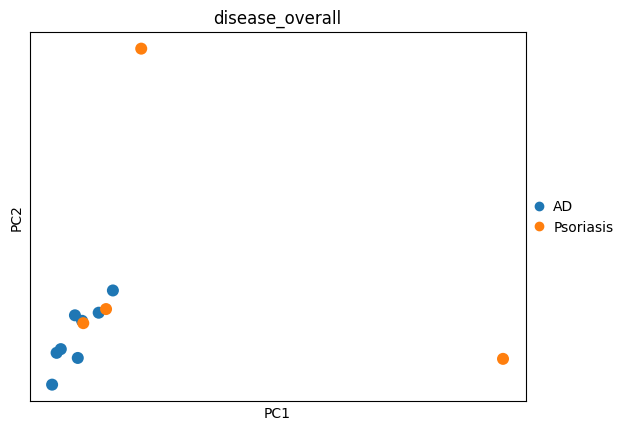

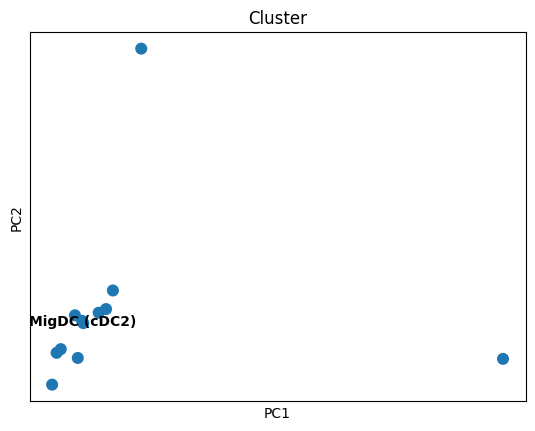

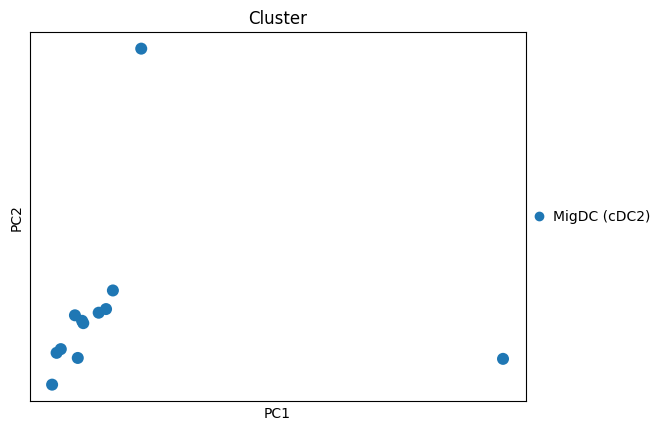

In [77]:
# sc.pl.pca(pdata, color=["disease_overall"], ncols=1, size=300) # "Efficacy", 
# sc.pl.pca(pdata, color=["Cluster"], ncols=1, size=300, legend_loc="on data") # "Efficacy", 
# sc.pl.pca(pdata, color=["Cluster"], ncols=1, size=300, #legend_loc="on data"
#          ) # "Efficacy", 


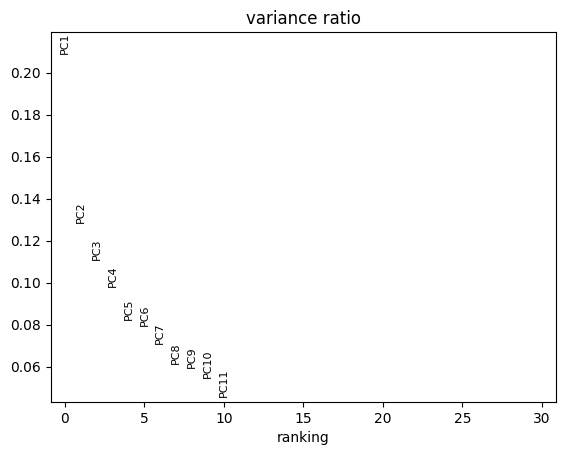

In [78]:
# sc.pl.pca_variance_ratio(pdata)


In [80]:
# try:
#     dc.get_metadata_associations(
#         pdata,
#         obs_keys=[ "disease_overall", "Patient", "psbulk_n_cells", "psbulk_counts"], # "Treatment", "Patient",
#         obsm_key="X_pca",
#         uns_key="pca_anova",
#         inplace=True,
#     )
#     pdata
# except:
#     1

In [81]:
# try:
#     dc.plot_associations(
#         pdata,
#         uns_key="pca_anova",
#         obsm_key="X_pca",
#         stat_col="p_adj",
#         obs_annotation_cols=["disease_overall",  #"Treatment", "Efficacy", 
#                              "Major celltype"],
#         titles=["Principle component scores", "Adjusted p-values from ANOVA"],
#     )
# except:
#     1

In [82]:
edgr = pt.tl.PyDESeq2(adata=pdata, design="~disease_overall")


In [84]:
edgr.fit()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.93 seconds.

Fitting dispersion trend curve...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 1.08 seconds.

Fitting LFCs...
... done in 0.85 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 2 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [85]:
pdata.obs.disease_overall

AD_BK18                 AD
AD_BK21                 AD
AD_BK22                 AD
AD_BK23                 AD
AD_BK25                 AD
AD_BK30                 AD
AD_BK39                 AD
AD_BK51                 AD
Psoriasis_CE3    Psoriasis
Psoriasis_CE4    Psoriasis
Psoriasis_CE5    Psoriasis
Psoriasis_CE6    Psoriasis
Name: disease_overall, dtype: category
Categories (2, object): ['AD', 'Psoriasis']

In [86]:
res_df = edgr.test_contrasts(edgr.contrast(column="disease_overall", baseline="AD", group_to_compare="Psoriasis"))

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0. 1.]
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A2ML1     3.409681        2.316316  0.886712  2.612252  0.008995  0.375606
AAMP     33.763611        0.087538  0.255061  0.343205  0.731444  0.999736
AAR2      1.473503        0.347568  0.914640  0.380005  0.703942  0.999736
AARSD1    4.152676        0.743890  0.624553  1.191076  0.233624  0.998285
ABAT      2.055295        0.287048  0.827177  0.347021  0.728576  0.999736
...            ...             ...       ...       ...       ...       ...
ZSCAN26   2.614116        0.718645  0.679640  1.057390  0.290334  0.998285
ZSWIM6    4.343922        0.010088  0.596764  0.016904  0.986513  0.999736
ZUP1      4.789182        1.120338  0.550421  2.035419  0.041809  0.753215
ZYG11B    1.813977        0.042509  0.883342  0.048123  0.961618  0.999736
ZYX      79.836207       -0.516680  0.301068 -1.716157  0.086133  0.872447

[4419 rows x 6 columns]


... done in 16.59 seconds.



In [87]:
# res_df.head(10)

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
0,TUBB2B,54.098525,-3.844201,0.560862,-6.854100,7.176279e-12,2.371043e-08,None
1,GBP1,53.547428,2.068149,0.311486,6.639625,3.144821e-11,5.195245e-08,None
2,CCL27,18.452198,-4.310081,0.674939,-6.385880,1.704148e-10,1.876835e-07,None
3,CXCL9,32.607650,3.995102,0.680212,5.873322,4.271480e-09,3.301930e-06,None
4,STAT1,61.665310,1.450517,0.248067,5.847276,4.996868e-09,3.301930e-06,None
5,CXCL10,17.112816,4.812365,0.920876,5.225858,1.733496e-07,9.545783e-05,None
6,UCP2,50.264516,-1.680913,0.325007,-5.171921,2.316999e-07,1.093624e-04,None
7,BATF3,41.906674,-1.587143,0.309812,-5.122921,3.008381e-07,1.242461e-04,None
8,CCN2,16.942128,2.410189,0.513306,4.695425,2.660532e-06,9.767107e-04,None
9,ALOX15,135.712263,-4.683027,1.019908,-4.591616,4.398265e-06,1.345579e-03,None


The set of differentially expressed genes can now be used for downstream tasks or as a first step, plotted in a volcano plot.

NaNs encountered, dropping rows with NaNs


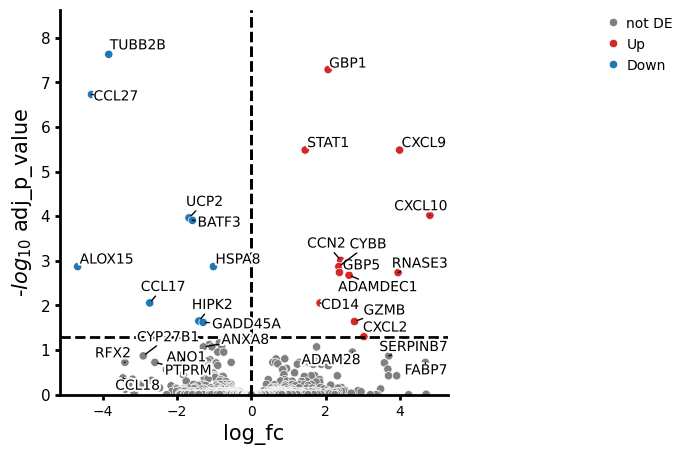

In [88]:
edgr.plot_volcano(res_df, 
                  log2fc_thresh=0,
                     to_label=15
                  ,
                     #    log2fc_thresh=0.
                 )

NaNs encountered, dropping rows with NaNs


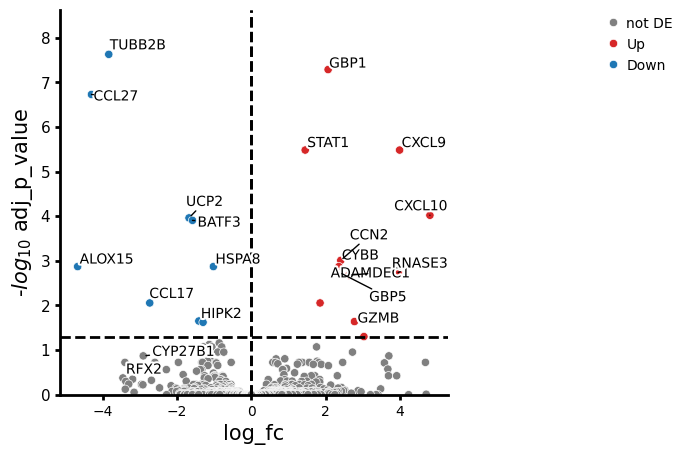

In [89]:
fig = edgr.plot_volcano(
    res_df,
    log2fc_thresh=0,
    to_label=10,
    return_fig=True
)

fig.savefig("fig3/supp3g_migdc_Dec.pdf", dpi=300, bbox_inches="tight")

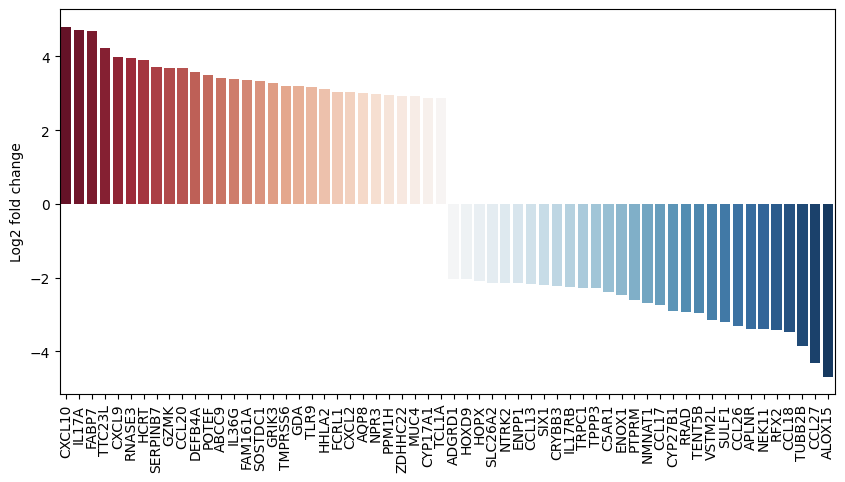

In [90]:
edgr.plot_fold_change(res_df, n_top_vars=30)
